# Clustering analysis using appraisal theory to derive facial expressions

The purpose of this analysis is to derive facial expression from data based on psychologically meaningful annotations, and then use these facial factors to train a classifier to predict outcomes.  This analysis is inspired by Stratou et al (2017) and Hoegen et al (2023), but draw from appraisal theory of emotions to form meaningful emotions clusters.  Using appraisals to understanding facial expressions in not new, and work is done by both Ong et all (2021) or Houlihan et al (2022), Houlihan et al (2023).

In [1]:
##### Standard packages
import numpy as np
import pandas as pd
import os
import math
import random
import re

##### Plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Decision trees and random forrests
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

## metrics 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

## misc
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE # oversampling for imbalanced datasets


##### Saving 
import pickle


## Data loading and cleaning

First thing we do is that we find all relevant participant and file names

Now we load all the files

In [2]:
d_au_annotation_unfiltered = pd.read_csv("../data/d_au_annotation.csv")
d_au_annotation_unfiltered.rename(columns=lambda x: x[:-2] if x.endswith("_r") else x, inplace=True)

## Factor analysis for all participants

First we add factors from the factor analysis conducted in R

In [3]:
d_au_control = d_au_annotation_unfiltered.query("~(control_other != control_other)").copy() # remove na

# define the factors
f1 = ["AU06", "AU07", "AU09", "AU10"]
f1_weights = [0.854, 0.712, 0.302, 0.735]
f2 = ["AU01", "AU02"]
f2_weights = [0.986, 0.800]
f3 = ["AU15", "AU17"]
f3_weights = [0.324, 0.991]
f4 = ["AU12", "AU14"]
f4_weights = [0.776, 0.458]
f5 = ["AU25", "AU26"]
f5_weights = [0.781, 0.689]
f6 = ["AU23"]
f6_weights = [0.817]
f7 = ["AU09", "AU15"]
f7_weights = [0.304, 0.328]


# Create expressivity metrics
# # mean activation
# d_au_control["f1_mean"]  = d_au_control[f1].mean(axis=1)
# d_au_control["f2_mean"]  = d_au_control[f2].mean(axis=1)
# d_au_control["f3_mean"]  = d_au_control[f3].mean(axis=1)
# d_au_control["f4_mean"]  = d_au_control[f4].mean(axis=1)
# d_au_control["f5_mean"]  = d_au_control[f5].mean(axis=1)
# d_au_control["f6_mean"]  = d_au_control[f6].mean(axis=1)
# d_au_control["f7_mean"]  = d_au_control[f7].mean(axis=1)

# weighted mean activation
d_au_control["f1_mean"]  = d_au_control[f1].mul(f1_weights).sum(axis=1)/len(f1)
d_au_control["f2_mean"]  = d_au_control[f2].mul(f2_weights).sum(axis=1)/len(f2)
d_au_control["f3_mean"]  = d_au_control[f3].mul(f3_weights).sum(axis=1)/len(f3)
d_au_control["f4_mean"]  = d_au_control[f4].mul(f4_weights).sum(axis=1)/len(f4)
d_au_control["f5_mean"]  = d_au_control[f5].mul(f5_weights).sum(axis=1)/len(f5)
d_au_control["f6_mean"]  = d_au_control[f6].mul(f6_weights).sum(axis=1)/len(f6)
d_au_control["f7_mean"]  = d_au_control[f7].mul(f7_weights).sum(axis=1)/len(f7)

# # sum variables
# d_au_control["f1_sum"]  = d_au_control[f1].sum(axis=1)
# d_au_control["f2_sum"]  = d_au_control[f2].sum(axis=1)
# d_au_control["f3_sum"]  = d_au_control[f3].sum(axis=1)
# d_au_control["f4_sum"]  = d_au_control[f4].sum(axis=1)
# d_au_control["f5_sum"]  = d_au_control[f5].sum(axis=1)
# d_au_control["f6_sum"]  = d_au_control[f6].sum(axis=1)
# d_au_control["f7_sum"]  = d_au_control[f7].sum(axis=1)

# weighted sum variables
d_au_control["f1_sum"]  = d_au_control[f1].mul(f1_weights).sum(axis=1)
d_au_control["f2_sum"]  = d_au_control[f2].mul(f2_weights).sum(axis=1)
d_au_control["f3_sum"]  = d_au_control[f3].mul(f3_weights).sum(axis=1)
d_au_control["f4_sum"]  = d_au_control[f4].mul(f4_weights).sum(axis=1)
d_au_control["f5_sum"]  = d_au_control[f5].mul(f5_weights).sum(axis=1)
d_au_control["f7_sum"]  = d_au_control[f7].mul(f7_weights).sum(axis=1)


# # sd
# d_au_control["f1_sd"]  = d_au_control[f1].std(axis=1)
# d_au_control["f2_sd"]  = d_au_control[f2].std(axis=1)
# d_au_control["f3_sd"]  = d_au_control[f3].std(axis=1)
# d_au_control["f4_sd"]  = d_au_control[f4].std(axis=1)
# d_au_control["f5_sd"]  = d_au_control[f5].std(axis=1)
# d_au_control["f6_sd"]  = 0 # as it's only one AU
# d_au_control["f7_sd"]  = d_au_control[f7].std(axis=1)

# sd
d_au_control["f1_sd"]  = d_au_control[f1].mul(f1_weights).std(axis=1)
d_au_control["f2_sd"]  = d_au_control[f2].mul(f2_weights).std(axis=1)
d_au_control["f3_sd"]  = d_au_control[f3].mul(f3_weights).std(axis=1)
d_au_control["f4_sd"]  = d_au_control[f4].mul(f4_weights).std(axis=1)
d_au_control["f5_sd"]  = d_au_control[f5].mul(f5_weights).std(axis=1)
d_au_control["f7_sd"]  = d_au_control[f7].mul(f7_weights).std(axis=1)


# change variables
d_au_control["f1_change"]  = d_au_control["f1_mean"].diff().fillna(0)
d_au_control["f2_change"]  = d_au_control["f2_mean"].diff().fillna(0)
d_au_control["f3_change"]  = d_au_control["f3_mean"].diff().fillna(0)
d_au_control["f4_change"]  = d_au_control["f4_mean"].diff().fillna(0)
d_au_control["f5_change"]  = d_au_control["f5_mean"].diff().fillna(0)
d_au_control["f6_change"]  = d_au_control["f6_mean"].diff().fillna(0)
d_au_control["f7_change"]  = d_au_control["f7_mean"].diff().fillna(0)

# max
# d_au_control["f1_max"]  = d_au_control[f1].max(axis=1)
# d_au_control["f2_max"]  = d_au_control[f2].max(axis=1)
# d_au_control["f3_max"]  = d_au_control[f3].max(axis=1)
# d_au_control["f4_max"]  = d_au_control[f4].max(axis=1)
# d_au_control["f5_max"]  = d_au_control[f5].max(axis=1)
# d_au_control["f6_max"]  = d_au_control[f6].max(axis=1)
# d_au_control["f7_max"]  = d_au_control[f7].max(axis=1)
# max
d_au_control["f1_max"]  = d_au_control[f1].mul(f1_weights).max(axis=1)
d_au_control["f2_max"]  = d_au_control[f2].mul(f2_weights).max(axis=1)
d_au_control["f3_max"]  = d_au_control[f3].mul(f3_weights).max(axis=1)
d_au_control["f4_max"]  = d_au_control[f4].mul(f4_weights).max(axis=1)
d_au_control["f5_max"]  = d_au_control[f5].mul(f5_weights).max(axis=1)
d_au_control["f7_max"]  = d_au_control[f7].mul(f7_weights).max(axis=1)

d_au_control.control_other.value_counts()



control_other
High      56226
Medium    42067
Low       20114
Name: count, dtype: int64

# Random Forests

In [4]:
# Base model
X = d_au_control.copy()
y = d_au_control["control_other"]
average_classification = []
f1_score_list = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["High"] * len(y_test)

    average_classification.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification))
print(np.mean(f1_score_list))

Accuracy: 0.4752132421248205
F1: 0.30616268759289733
Accuracy: 0.4737494017960195
F1: 0.3045816275529192
Accuracy: 0.4725670692227571
F1: 0.30330657201462147
Accuracy: 0.47662078090251386
F1: 0.30768545550236254
Accuracy: 0.4744250204093123
F1: 0.3053110153107583
Accuracy: 0.4767615347802832
F1: 0.30783786778394084
Accuracy: 0.4729048785294035
F1: 0.3036706950963438
Accuracy: 0.4725389184472032
F1: 0.3032762348756334
Accuracy: 0.47284857697829574
F1: 0.30360999799328875
Accuracy: 0.4748754328181741
F1: 0.3057975903271408
0.47425048560087835
0.30512397440499067


### AU model

In [5]:
#split dataset in features and target variable
feature_cols_au = [col_name for col_name in d_au_control.columns if "au" in col_name.lower()]
X_au = d_au_control[feature_cols_au] # Features
y_au = d_au_control["control_other"] # Target variable


X_train_au, X_test_au, y_train_au, y_test_au = train_test_split(X_au, y_au, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au.fit(X_train_au, y_train_au)

print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
print(grid_seach_au.score(X_test_au, y_test_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6993750301626369
0.6652872786645272


In [56]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au = []
f1_score_list_au = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au, y_au, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au))
print(np.mean(f1_score_list_au))

Accuracy: 0.663626382906849
F1: 0.6296103063109008
Accuracy: 0.6630352166202179
F1: 0.6291850118824436
Accuracy: 0.6613461700869859
F1: 0.6268735538028453
Accuracy: 0.6655687864200659
F1: 0.6327244304226579
Accuracy: 0.6697351012020382
F1: 0.6362596052659111
Accuracy: 0.6698758550798074
F1: 0.6364997823764293
Accuracy: 0.6688624271598682
F1: 0.6356818779390221
Accuracy: 0.6603608929426006
F1: 0.626594491214383
Accuracy: 0.6677363961377136
F1: 0.6343978967844086
Accuracy: 0.6587562987360301
F1: 0.6229496649882195
0.6648903527292176
0.6310776620987222


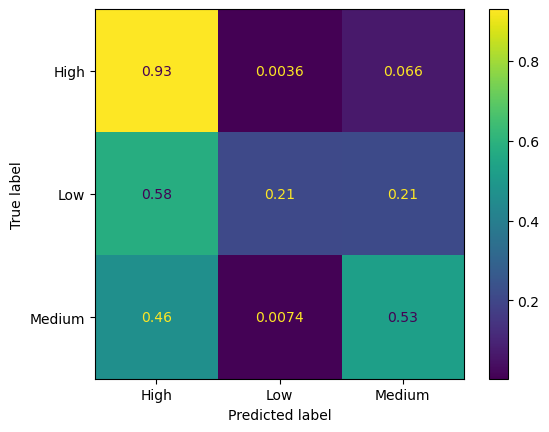

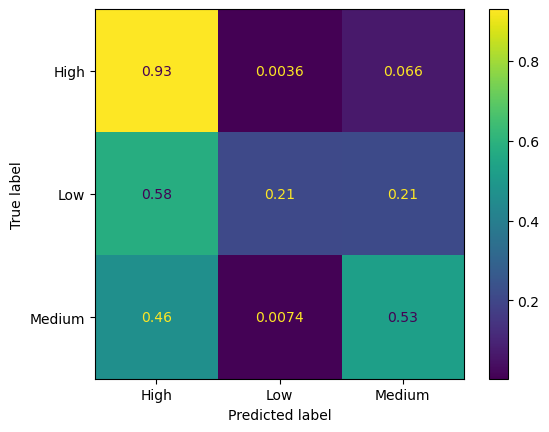

In [44]:
y_pred = best_rf_au.predict(X_test_au)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au, y_pred, normalize="true").plot()

<Axes: >

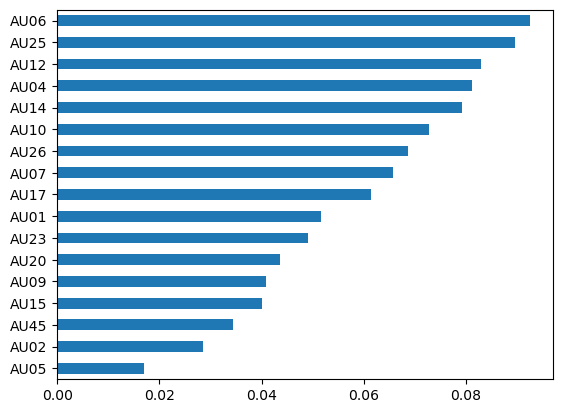

In [14]:
feature_importance_au = pd.Series(best_rf_au.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au.plot.barh()

In [15]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_full = re.compile(r"f\d+_(mean|sum|sd|change|max)")

# Extract matching column names
feature_cols_f_full = [col_name for col_name in d_au_control.columns if pattern_f_full.match(col_name)]
X_ff = d_au_control[feature_cols_f_full] # Features
y_ff = d_au_control["control_other"] # Target variable


X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, y_ff, test_size=0.3, random_state=1) # 70% training and 30% test

In [16]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_full)))]}

rf = RandomForestClassifier()

grid_seach_ff = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_ff.fit(X_train_ff, y_train_ff)

# print best fits
print(grid_seach_ff.best_params_)
print(grid_seach_ff.score(X_train_ff, y_train_ff))
best_rf_ff = grid_seach_ff.best_estimator_

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [4, 6, 8, 10],
                         'max_features': [5], 'n_estimators': [10, 30, 50]},
             scoring='accuracy')

In [45]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_full))), random_state=1)

average_classification_ff = []
f1_score_list_ff = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_ff, y_ff, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_ff.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_ff.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_ff))
print(np.mean(f1_score_list_ff))

Accuracy: 0.6145314303409058
F1: 0.5688494885153649
Accuracy: 0.6190918559806323
F1: 0.5735635378808814
Accuracy: 0.6170931509163078
F1: 0.5708220074594597
Accuracy: 0.6190074036539707
F1: 0.5745761795137112
Accuracy: 0.6204430932072179
F1: 0.5752514942225914
Accuracy: 0.6186132927962166
F1: 0.5729683125016085
Accuracy: 0.6229485122315119
F1: 0.5792211466578681
Accuracy: 0.6179658249584776
F1: 0.5720407311254282
Accuracy: 0.6192607606339555
F1: 0.5739542074616409
Accuracy: 0.6165301354052304
F1: 0.5719517089850326
0.6185485460124427
0.5733198814323588


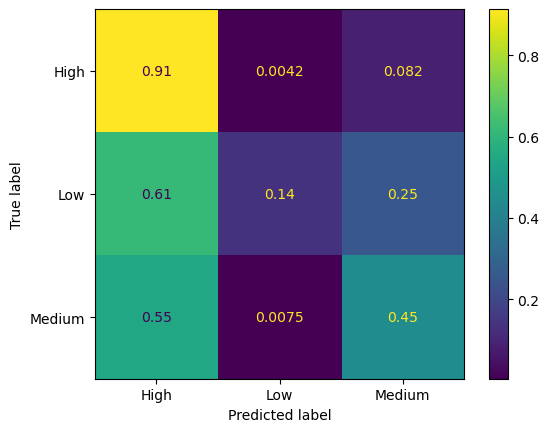

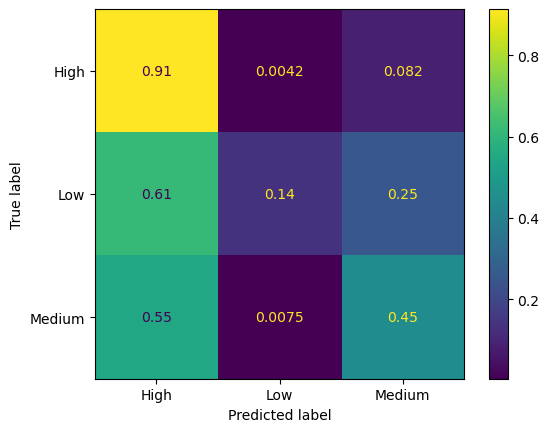

In [19]:
y_pred = best_rf_ff.predict(X_test_ff)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_ff, y_pred, normalize="true").plot()
plt.show()

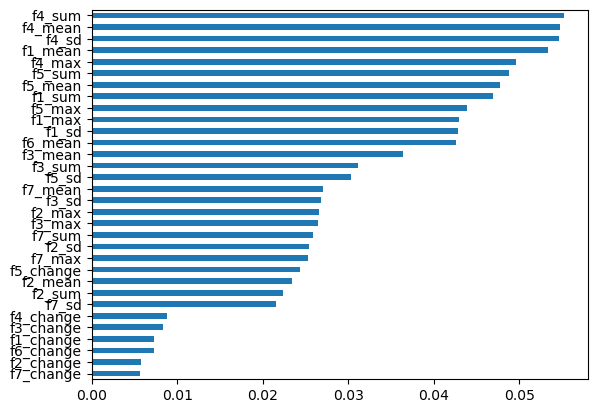

Index(['f7_change', 'f2_change', 'f6_change', 'f1_change', 'f3_change',
       'f4_change', 'f7_sd', 'f2_sum', 'f2_mean', 'f5_change', 'f7_max',
       'f2_sd', 'f7_sum', 'f3_max', 'f2_max', 'f3_sd', 'f7_mean', 'f5_sd',
       'f3_sum', 'f3_mean', 'f6_mean', 'f1_sd', 'f1_max', 'f5_max', 'f1_sum',
       'f5_mean', 'f5_sum', 'f4_max', 'f1_mean', 'f4_sd', 'f4_mean', 'f4_sum'],
      dtype='object')


In [20]:
feature_importance_ff = pd.Series(best_rf_ff.feature_importances_, index=X_train_ff.columns).sort_values(ascending=True)
feature_importance_ff.plot.barh()

plt.show()
print(feature_importance_ff.index)

In [13]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in d_au_control.columns if pattern_f.match(col_name)]
X_f = d_au_control[feature_cols_f] # Features
y_f = d_au_control["control_other"] # Target variable


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=1) # 70% training and 30% test

In [22]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()
# #£££#wdsdljsldj 
grid_seach_f = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f.fit(X_train_f, y_train_f)

# print best fits
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6720235509869215


In [54]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f = []
f1_score_list_f = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f))
print(np.mean(f1_score_list_f))

Accuracy: 0.6407398023815556
F1: 0.6027316244289099
Accuracy: 0.6445120063057738
F1: 0.6062030479533502
Accuracy: 0.6475522900655913
F1: 0.6113309846021958
Accuracy: 0.648453114883315
F1: 0.6111549971265626
Accuracy: 0.637502463192861
F1: 0.5976660321444565
Accuracy: 0.6381780818061538
F1: 0.599787487517231
Accuracy: 0.6381780818061538
F1: 0.5994872747671289
Accuracy: 0.6432733721814036
F1: 0.6046139917473872
Accuracy: 0.6411620640148636
F1: 0.604106859433883
Accuracy: 0.6434704276102806
F1: 0.6063083090872525
0.6423021704247953
0.6043390608808357


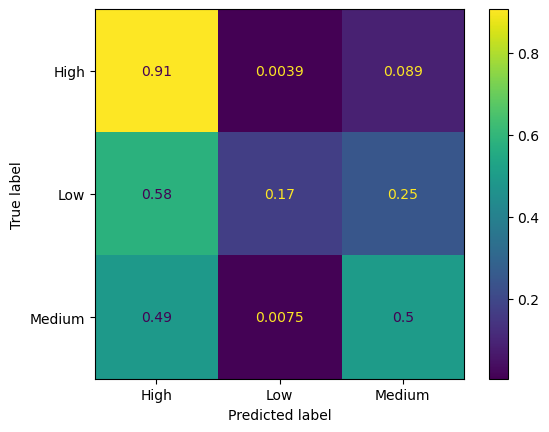

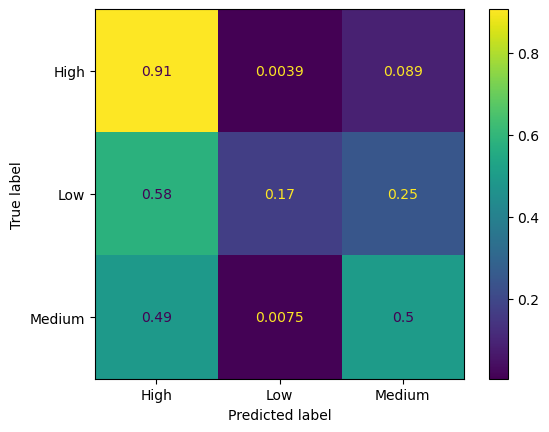

In [25]:
y_pred = best_rf_f.predict(X_test_f)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred, normalize="true").plot()

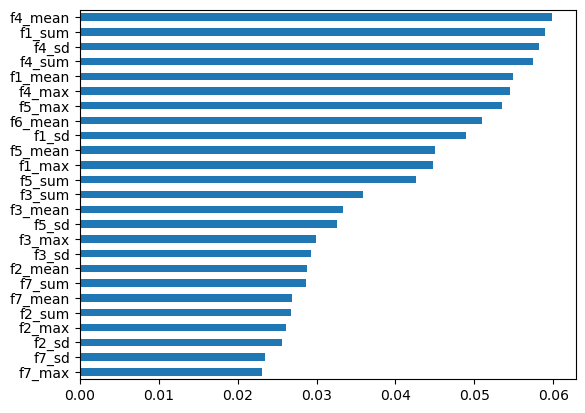

Index(['f7_max', 'f7_sd', 'f2_sd', 'f2_max', 'f2_sum', 'f7_mean', 'f7_sum',
       'f2_mean', 'f3_sd', 'f3_max', 'f5_sd', 'f3_mean', 'f3_sum', 'f5_sum',
       'f1_max', 'f5_mean', 'f1_sd', 'f6_mean', 'f5_max', 'f4_max', 'f1_mean',
       'f4_sum', 'f4_sd', 'f1_sum', 'f4_mean'],
      dtype='object')


In [26]:
feature_importance_f = pd.Series(best_rf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=True)
feature_importance_f.plot.barh()

plt.show()
print(feature_importance_f.index)

## SMOTE (oversampling)

##### AU oversampling

In [6]:
smote=SMOTE(sampling_strategy="auto")
print(y_au.value_counts())
X_au_smote, y_au_smote = smote.fit_resample(X_au, y_au)
print(y_au_smote.value_counts())



control_other
High      56226
Medium    42067
Low       20114
Name: count, dtype: int64
control_other
High      56226
Low       56226
Medium    56226
Name: count, dtype: int64


In [36]:
# Au oversampling
X_train_au_smote, X_test_au_smote, y_train_au_smote, y_test_au_smote = train_test_split(X_au_smote, y_au_smote, test_size=0.3, random_state=1) # 70% training and 30% test

In [7]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au_smote.fit(X_train_au_smote, y_train_au_smote)

#print best fits
print(grid_seach_au_smote.best_params_)
print(grid_seach_au_smote.score(X_train_au_smote, y_train_au_smote))
best_rf_au_smote = grid_seach_au_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.7343191557836611


In [18]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au_smote = []
f1_score_list_au_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au_smote))
print(np.mean(f1_score_list_au_smote))

Accuracy: 0.7032250414986958
F1: 0.7032416578235264
Accuracy: 0.7006560746186072
F1: 0.7006596938082108
Accuracy: 0.7030669512291519
F1: 0.7029162110615373
Accuracy: 0.7015255711010987
F1: 0.7015509179216368
Accuracy: 0.7038574025768713
F1: 0.7039309534500497
Accuracy: 0.6984230495612995
F1: 0.6984874167853476
Accuracy: 0.7054975891233894
F1: 0.7056355991716258
Accuracy: 0.6998853845545807
F1: 0.7000393936396402
Accuracy: 0.7046873764919769
F1: 0.7046845639737425
Accuracy: 0.7073353885068374
F1: 0.7073620728690916
0.702815982926251
0.702850848050441


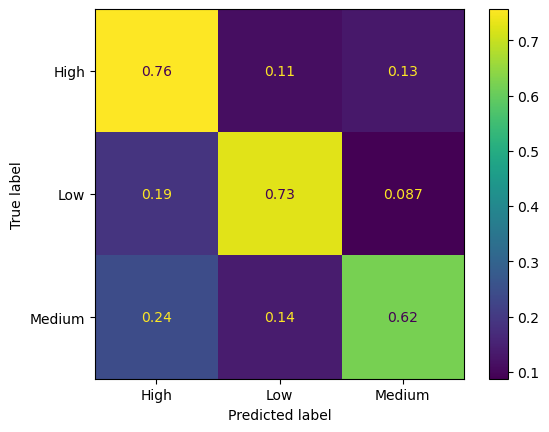

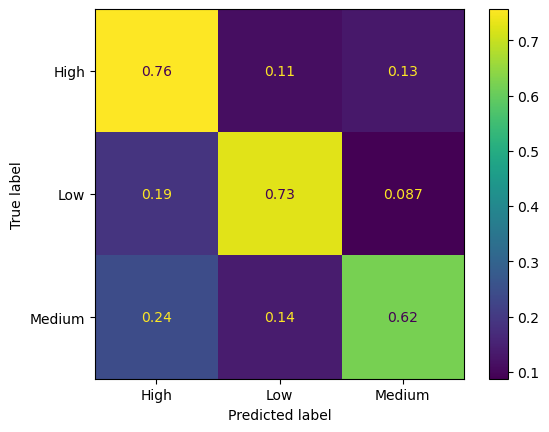

<Axes: >

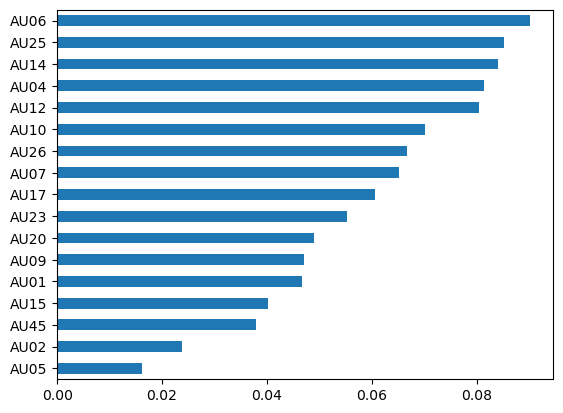

In [9]:
y_pred = best_rf_au_smote.predict(X_test_au_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_au_smote = pd.Series(best_rf_au_smote.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au_smote.plot.barh()

### BASE model

In [10]:
average_classification_smote = []
f1_score_list_smote = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["High"] * len(y_test)

    average_classification_smote.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification_smote))
print(np.mean(f1_score_list_smote))

Accuracy: 0.3324835981345348
F1: 0.16592375798583836
Accuracy: 0.33398545569520194
F1: 0.16723763237403474
Accuracy: 0.3337285590071931
F1: 0.16701262088880098
Accuracy: 0.33279977867362265
F1: 0.16620004663481294
Accuracy: 0.33418306853213187
F1: 0.16741079380720972
Accuracy: 0.333926171844123
F1: 0.1671856967740805
Accuracy: 0.33364951387242114
F1: 0.1669434089681709
Accuracy: 0.3302110505098411
F1: 0.16394291392635843
Accuracy: 0.3348351908940005
F1: 0.16798269303333757
Accuracy: 0.3348351908940005
F1: 0.16798269303333757
0.3334637578057071
0.1667822257425982


### Factor subset

In [43]:
# Create the factors on the smote'd dataset
X_f_smote = X_au_smote.copy()
y_f_smote = y_au_smote.copy()

# weighted mean activation
X_f_smote["f1_mean"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)/len(f1)
X_f_smote["f2_mean"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)/len(f2)
X_f_smote["f3_mean"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)/len(f3)
X_f_smote["f4_mean"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)/len(f4)
X_f_smote["f5_mean"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)/len(f5)
X_f_smote["f6_mean"]  = X_f_smote[f6].mul(f6_weights).sum(axis=1)/len(f6)
X_f_smote["f7_mean"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)/len(f7)

# weighted sum variables
X_f_smote["f1_sum"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)
X_f_smote["f2_sum"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)
X_f_smote["f3_sum"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)
X_f_smote["f4_sum"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)
X_f_smote["f5_sum"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)
X_f_smote["f7_sum"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)


# sd
X_f_smote["f1_sd"]  = X_f_smote[f1].mul(f1_weights).std(axis=1)
X_f_smote["f2_sd"]  = X_f_smote[f2].mul(f2_weights).std(axis=1)
X_f_smote["f3_sd"]  = X_f_smote[f3].mul(f3_weights).std(axis=1)
X_f_smote["f4_sd"]  = X_f_smote[f4].mul(f4_weights).std(axis=1)
X_f_smote["f5_sd"]  = X_f_smote[f5].mul(f5_weights).std(axis=1)
X_f_smote["f7_sd"]  = X_f_smote[f7].mul(f7_weights).std(axis=1)

# max
X_f_smote["f1_max"]  = X_f_smote[f1].mul(f1_weights).max(axis=1)
X_f_smote["f2_max"]  = X_f_smote[f2].mul(f2_weights).max(axis=1)
X_f_smote["f3_max"]  = X_f_smote[f3].mul(f3_weights).max(axis=1)
X_f_smote["f4_max"]  = X_f_smote[f4].mul(f4_weights).max(axis=1)
X_f_smote["f5_max"]  = X_f_smote[f5].mul(f5_weights).max(axis=1)
X_f_smote["f7_max"]  = X_f_smote[f7].mul(f7_weights).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in X_f_smote.columns if pattern_f.match(col_name)]

X_f_smote = X_f_smote[feature_cols_f]

In [15]:
X_train_f_smote, X_test_f_smote, y_train_f_smote, y_test_f_smote = train_test_split(X_f_smote, y_f_smote, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()

grid_seach_f_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote.fit(X_train_f_smote, y_train_f_smote)

# best parameters
print(grid_seach_f_smote.best_params_)
print(grid_seach_f_smote.score(X_train_f_smote, y_train_f_smote))
best_rf_f_smote = grid_seach_f_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6915747751410133


In [16]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f_smote = []
f1_score_list_f_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote, y_f_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote))
print(np.mean(f1_score_list_f_smote))


Accuracy: 0.6512923879535215
F1: 0.651037037059259
Accuracy: 0.653762548415145
F1: 0.6536032515028884
Accuracy: 0.6495929175559244
F1: 0.6494323316641529
Accuracy: 0.6579321792743656
F1: 0.6575344581393768
Accuracy: 0.6529523357837325
F1: 0.6527557283807786
Accuracy: 0.6509762074144336
F1: 0.6504163818748673
Accuracy: 0.6578136115722077
F1: 0.6578372948733687
Accuracy: 0.6558770057702948
F1: 0.655733884482719
Accuracy: 0.6581100308276026
F1: 0.6579778585030068
Accuracy: 0.6460161252074935
F1: 0.6458418274520121
0.6534325349774722
0.6532170053932431


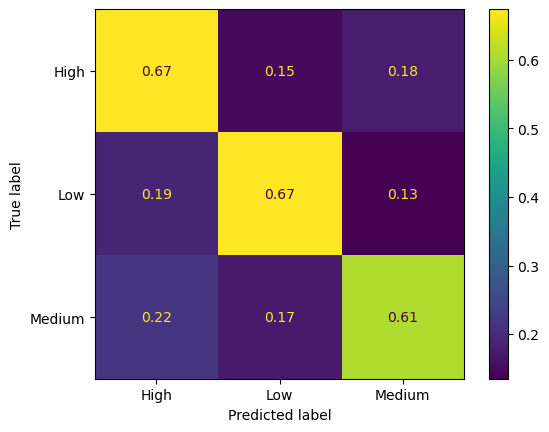

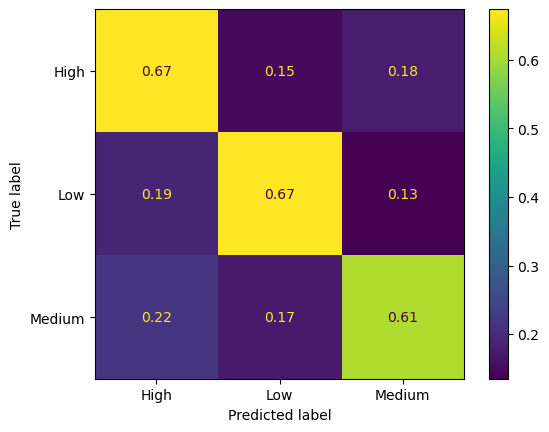

<Axes: >

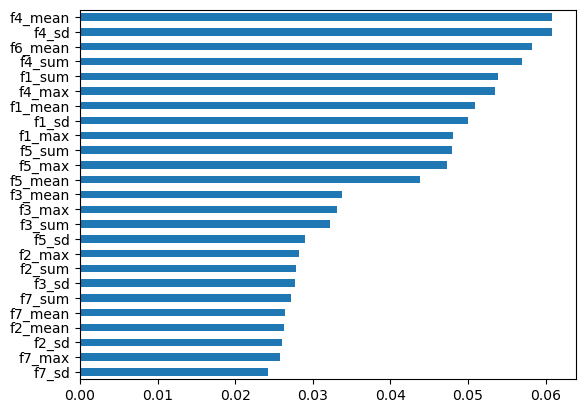

In [17]:
y_pred = best_rf_f_smote.predict(X_test_f_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote = pd.Series(best_rf_f_smote.feature_importances_, index=X_train_f_smote.columns).sort_values(ascending=True)
feature_importance_f_smote.plot.barh()

In [24]:
print(list(feature_importance_f_smote))

[0.024206629026844288, 0.025771071166516415, 0.025976912695421385, 0.026257023471132127, 0.026469886865856006, 0.02719266984359433, 0.027647128483871842, 0.027878597914083834, 0.02825899767748343, 0.029020547969639487, 0.03222997450791472, 0.03310830596033558, 0.033810934776744773, 0.043795675932854945, 0.04729156786738517, 0.04788077862745833, 0.04805280511200789, 0.04999706028104062, 0.050899549949953965, 0.053483382402504595, 0.05389961426500231, 0.056923432129205365, 0.05822781691807994, 0.0608570083915616, 0.06086262776350701]


# Stratou factors

In [7]:
f1_strat = ["AU06", "AU07", "AU12"]
f1_weights_strat = [0.982, 0.446, 0.882]
f2_strat = ["AU01", "AU02"]
f2_weights_strat = [0.981, 0.873]
f3_strat = ["AU20", "AU25", "AU26"]
f3_weights_strat = [0.377, 0.951, 0.786]
f4_strat = ["AU14", "AU17", "AU23"]
f4_weights_strat = [0.724, 0.632, 0.710]
f5_strat = ["AU04", "AU07", "AU09"]
f5_weights_strat = [0.703, 0.384, 0.390]
f6_strat = ["AU10", "AU15", "AU17"]
f6_weights_strat = [0.488, 0.504, 0.420]

In [8]:
# Create the factors on the smote'd dataset
X_f_smote_strat = X_au_smote.copy()
y_f_smote_strat = y_au_smote.copy()

# weighted mean activation
X_f_smote_strat["f1_mean"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)/len(f1_strat)
X_f_smote_strat["f2_mean"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)/len(f2_strat)
X_f_smote_strat["f3_mean"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)/len(f3_strat)
X_f_smote_strat["f4_mean"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)/len(f4_strat)
X_f_smote_strat["f5_mean"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)/len(f5_strat)
X_f_smote_strat["f6_mean"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)/len(f6_strat)

# weighted sum variables
X_f_smote_strat["f1_sum"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)
X_f_smote_strat["f2_sum"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)
X_f_smote_strat["f3_sum"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)
X_f_smote_strat["f4_sum"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)
X_f_smote_strat["f5_sum"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)
X_f_smote_strat["f6_sum"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)


# sd
X_f_smote_strat["f1_sd"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).std(axis=1)
X_f_smote_strat["f2_sd"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).std(axis=1)
X_f_smote_strat["f3_sd"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).std(axis=1)
X_f_smote_strat["f4_sd"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).std(axis=1)
X_f_smote_strat["f5_sd"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).std(axis=1)
X_f_smote_strat["f6_sd"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).std(axis=1)

# max
X_f_smote_strat["f1_max"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).max(axis=1)
X_f_smote_strat["f2_max"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).max(axis=1)
X_f_smote_strat["f3_max"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).max(axis=1)
X_f_smote_strat["f4_max"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).max(axis=1)
X_f_smote_strat["f5_max"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).max(axis=1)
X_f_smote_strat["f6_max"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_strat = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f_strat = [col_name for col_name in X_f_smote_strat.columns if pattern_f_strat.match(col_name)]

X_f_smote_strat = X_f_smote_strat[feature_cols_f_strat]

In [9]:
X_train_f_smote_strat, X_test_f_smote_strat, y_train_f_smote_strat, y_test_f_smote_strat = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_strat)))]}

rf = RandomForestClassifier()

grid_seach_f_smote_strat = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote_strat.fit(X_train_f_smote_strat, y_train_f_smote_strat)

# best parameters
print(grid_seach_f_smote_strat.best_params_)
print(grid_seach_f_smote_strat.score(X_train_f_smote_strat, y_train_f_smote_strat))
best_rf_f_smote_strat = grid_seach_f_smote_strat.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6770669241323238


In [10]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_strat))))

average_classification_f_smote_strat = []
f1_score_list_f_smote_strat = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote_strat.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote_strat.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote_strat))
print(np.mean(f1_score_list_f_smote_strat))

Accuracy: 0.6512923879535215
F1: 0.6507432023698112
Accuracy: 0.6547308513161015
F1: 0.6541876569368111
Accuracy: 0.6511935815350565
F1: 0.6504152529236011
Accuracy: 0.6592561852817959
F1: 0.6586945151987457
Accuracy: 0.6595723658208837
F1: 0.6589465530500365
Accuracy: 0.6491976918820647
F1: 0.6484202595127675
Accuracy: 0.6512331041024425
F1: 0.6505494795775872
Accuracy: 0.652221168287092
F1: 0.6515650783197584
Accuracy: 0.6544937159117856
F1: 0.6537915826610923
Accuracy: 0.6542961030748558
F1: 0.6536824763186436
0.6537487155165599
0.6530996056868855


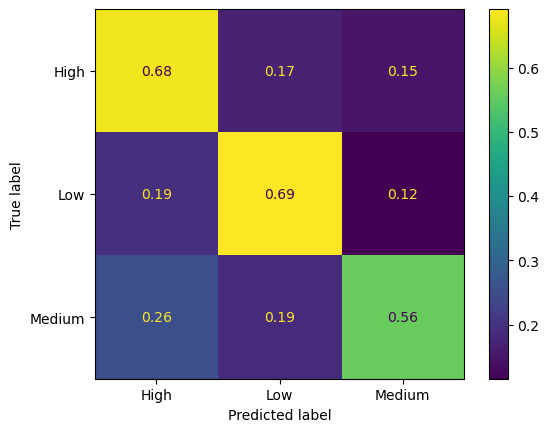

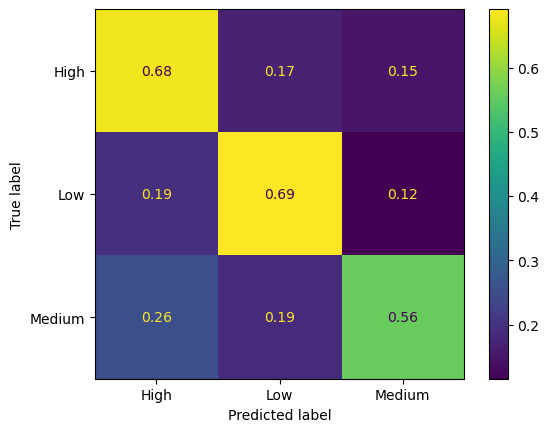

<Axes: >

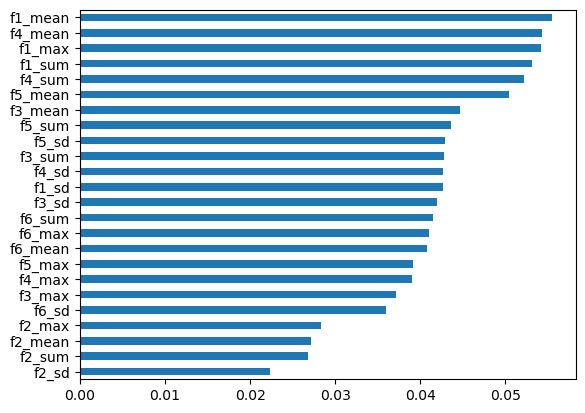

In [11]:
y_pred = best_rf_f_smote_strat.predict(X_test_f_smote_strat)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote_strat, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [14]:
print(list(feature_importance_f_smote_strat))

[0.022285272766647376, 0.02678759892492671, 0.027111943161267745, 0.02831648407627444, 0.03599242101192905, 0.03709760937527504, 0.0390046746375293, 0.03915480764568704, 0.040817172145355955, 0.041002566925606464, 0.04149888880470108, 0.04200822658388875, 0.042640770542228916, 0.04265181955675791, 0.042772903684521524, 0.04284379408018923, 0.04361763451394341, 0.04469116423936107, 0.05047400619057405, 0.05221493416292386, 0.053060464702652875, 0.05413963569017941, 0.05430467526939597, 0.05551053130818277]
